In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# 1.Simple Linear Regression Demo

 A straight-line fit is a model of the form $$
y = ax + b
$$ where $a$ is commonly known as the slope, and $b$ is commonly known as the intercept.

Let's generate some data points with some noise to formulate a set of points of y = 2x-5

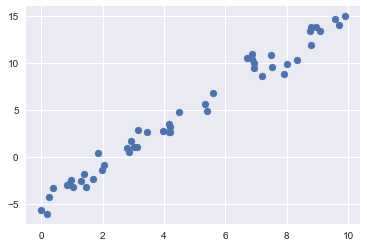

In [5]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);


We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

Train a regressor to fit those data and plot them according to OLS

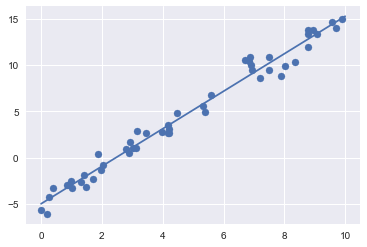

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = True)
model.fit(x[:,np.newaxis],y)

xfit=np.linspace(0,10,1000)
yfit = model.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit,yfit)

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore. Here the relevant parameters are coef_ and intercept_:

In [7]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


We see that the results are very close to the inputs, as we might hope.

When we have more than one x: it's hard to visualize the result but we can see the model's parameters whether fits our setting

In [8]:
rng = np.random.RandomState(1)
X = 10 *rng.rand(100,3)
y=0.5 + np.dot(X,[1.5,-2.,1.])

model.fit(X,y)
print(model.intercept_)
print(model.coef_)

0.5000000000000144
[ 1.5 -2.   1. ]



Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single LinearRegression estimator to fit lines, planes, or hyperplanes to our data. It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

# 2.Basis Function Regression

The idea is to take our multidimensional linear model: $$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$ and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$. That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression: $$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$ Notice that this is still a linear model—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other. What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

# 2.1 Polynomial basis functions

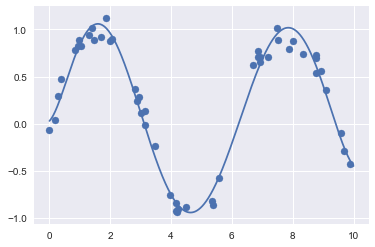

In [9]:
from sklearn.preprocessing import PolynomialFeatures

# How to use polynomial transformation
x = np.array([2,3,4])
poly = PolynomialFeatures(3,include_bias = False)
poly.fit_transform(x[:,None])

#sklearn feature--pipline
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),LinearRegression())

#create some data points : a sin curve with some random noise
rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = np.sin(x) + 0.1 *rng.randn(50)
poly_model.fit(x[:,np.newaxis],y)
yfit = poly_model.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit,yfit)

# Gaussian basis functions（RBF）

These Gaussian basis functions are not built into Scikit-Learn, but we can write a custom transformer that will create them

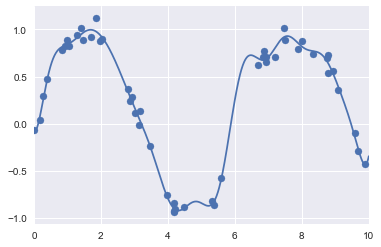

In [10]:
from sklearn.base import BaseEstimator,TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);


# 3.Regularization

Be careful of overfitting! Below it's an example when we set too many parameters to capture the real pattern behind the data we have

(-1.5, 1.5)

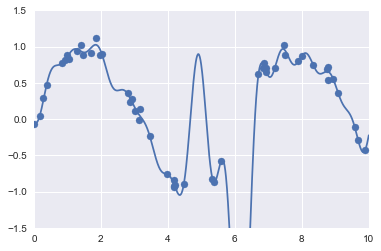

In [11]:
# An example of overfitting 

model = make_pipeline(GaussianFeatures(30),LinearRegression())
model.fit(x[:,np.newaxis],y)

plt.scatter(x,y)
plt.plot(xfit,model.predict(xfit[:,np.newaxis]))
plt.xlim(0,10)
plt.ylim(-1.5,1.5)


### 3.1 Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization, sometimes also called Tikhonov regularization. This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be $$
P = \alpha\sum_{n=1}^N \theta_n^2
$$ where $\alpha$ is a free parameter that controls the strength of the penalty. This type of penalized model is built into Scikit-Learn with the Ridge estimator:

In [12]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))

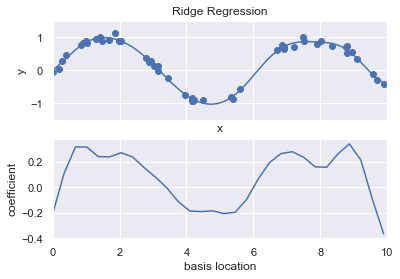

In [26]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30),Ridge(alpha=0.1))
basis_plot(model, title = 'Ridge Regression')

3.2Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: $$
P = \alpha\sum_{n=1}^N |\theta_n|
$$ Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:

c:\users\tianjiayang\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


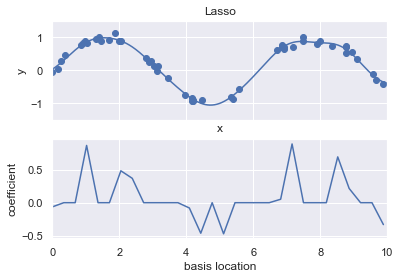

In [28]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha = 0.001))
basis_plot(model , title = 'Lasso')

相比于L2正则化， L1 更倾向于将一些系数设置为0 （思考：为什么？）